In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.interpolate import interp1d
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

sns.set(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (8,5)

## Data Preparation

In [12]:
df = pd.read_excel("mp_dataset_processed.xlsx")
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (4913, 13)


,Formulation Index,Drug MW,Drug TPSA,Drug LogP,Polymer MW,LA/GA,Initial Drug-to-Polymer Ratio,Particle Size,Drug Loading Capacity,Drug Encapsulation Efficiency,Solubility Enhancer Concentration,Time,Release
0,1,639.83,116.04,5.7289,75.0,3.0,0.666667,47.723,35.41,88.3,0.5,0.000000,0.000000
1,1,639.83,116.04,5.7289,75.0,3.0,0.666667,47.723,35.41,88.3,0.5,1.889764,0.062622
2,1,639.83,116.04,5.7289,75.0,3.0,0.666667,47.723,35.41,88.3,0.5,7.181102,0.056751
3,1,639.83,116.04,5.7289,75.0,3.0,0.666667,47.723,35.41,88.3,0.5,13.984252,0.058708
4,1,639.83,116.04,5.7289,75.0,3.0,0.666667,47.723,35.41,88.3,0.5,27.968504,0.058708


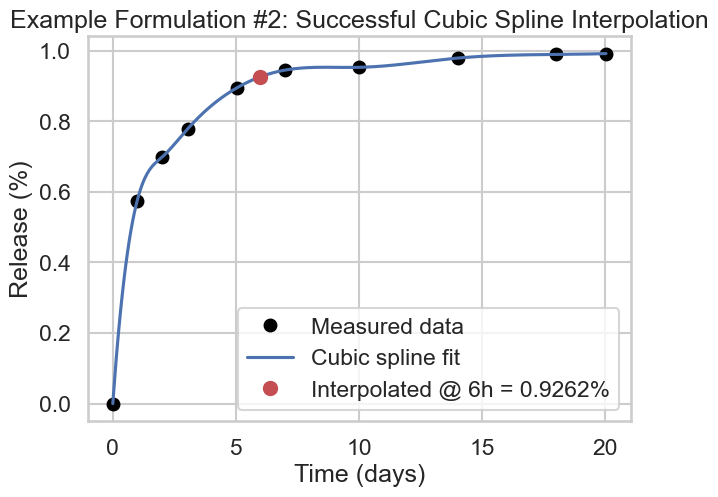


Formulations without t=6 h coverage: 13 / 318 total
Formulations WITH t=6 h coverage: 305 / 318 total
Removed 4 formulations due to invalid interpolated values (< 0 or > 1)
Rows in df_interp_rows (one per formulation): 301



,Formulation Index,Drug MW,Drug TPSA,Drug LogP,Polymer MW,LA/GA,Initial Drug-to-Polymer Ratio,Particle Size,Drug Loading Capacity,Drug Encapsulation Efficiency,Solubility Enhancer Concentration,Time,Release
0,1.0,639.830,116.04,5.7289,75.0,3.0,0.666667,47.723,35.41,88.3,0.5,6.0,0.066130
1,2.0,392.467,94.83,1.8957,12.0,1.0,0.111111,1.800,6.60,66.0,0.0,6.0,0.926233
2,3.0,392.467,94.83,1.8957,12.0,1.0,0.111111,12.500,8.60,85.9,0.0,6.0,0.548233
3,4.0,392.467,94.83,1.8957,12.0,1.0,0.111111,29.300,8.70,86.8,0.0,6.0,0.442395
4,5.0,392.467,94.83,1.8957,12.0,1.0,0.111111,58.000,9.00,90.1,0.0,6.0,0.409075
5,6.0,392.467,94.83,1.8957,31.0,1.0,0.111111,1.500,5.80,58.1,0.0,6.0,0.389358
6,7.0,392.467,94.83,1.8957,31.0,1.0,0.111111,12.900,7.50,75.3,0.0,6.0,0.160690
7,8.0,392.467,94.83,1.8957,31.0,1.0,0.111111,34.800,8.50,85.3,0.0,6.0,0.086132
8,9.0,392.467,94.83,1.8957,31.0,1.0,0.111111,61.300,8.60,86.1,0.0,6.0,0.050755
9,10.0,392.467,94.83,1.8957,12.0,1.0,0.052632,35.000,4.30,86.0,0.0,6.0,0.607708


In [13]:
# The dataset contains release values over time. This cell previews the time distributions to find a ...
    # ... a shared measurement time that can be used as the target for our proof-of-concept regression model.

        # # In this phase, we aim to predict the fraction of drug released at a single, common...
        # ...time (ex: t=20).  This simplifies the problem to a regression task and...
        # ...lets us test whether formulation descriptors alone contain predictive signal.

# Initial plan: round to nearest tenth and see if the formulation release profiles share a timepoint. It showed...
    # ...that there is no easily identifiable point, since these values are collected from mulitple sources. 
        # I decided to use cubic spline interpolation to approximte the value of a shared timepoint...
            # ...that is within the range of mostly every feature set's release profile. 

target_time = 6
time_col = [c for c in df.columns if c.lower().startswith('time')][0]
release_col = [c for c in df.columns if 'release' in c.lower()][0]

formulation_ranges = []
start_idx = df.index[df[time_col] == 0].tolist()
start_idx.append(len(df))

example_true = None
example_curve = None
found = 0

# List to collect interpolated rows (one per formulation)
interp_rows = []
removed_count = 0

for i in range(len(start_idx)-1):
    sub = df.iloc[start_idx[i]:start_idx[i+1]].copy()
    tmin, tmax = sub[time_col].min(), sub[time_col].max()
    covers = tmin <= target_time <= tmax
    formulation_ranges.append((i+1, tmin, tmax, covers))
    
    # For formulations that cover the target time, interpolate and create single row
    if covers and len(sub) > 3:
        # Sort and remove duplicate time values (keep first occurrence)
        sub_sorted = sub.sort_values(time_col)
        # Check for duplicates and print example. These prevent spline interpolation. Only 3 instances. 
        #duplicates = sub_sorted[sub_sorted.duplicated(subset=time_col, keep=False)]
        #if len(duplicates) > 0:
        #    print(f"Formulation {i+1} has duplicate time values:")
        #    print(duplicates[[time_col, release_col]])
        #    print()
        
        sub_sorted = sub_sorted.drop_duplicates(subset=time_col, keep='first')
        
        # Check if we still have enough points after removing duplicates
        if len(sub_sorted) > 3:
            try:
                # Perform cubic spline interpolation
                f_spline = interp1d(sub_sorted[time_col], sub_sorted[release_col], 
                                   kind='cubic', fill_value="extrapolate")
                interpolated_release = float(f_spline(target_time))
                
                # REMOVE rows with physically impossible values (outside [0, 1])
                if interpolated_release < 0 or interpolated_release > 1:
                    removed_count += 1
                    continue  # Skip this formulation
                
                # First row for formulation features, then update time and release values
                formulation_row = sub.iloc[0].copy()
                formulation_row[time_col] = target_time
                formulation_row[release_col] = interpolated_release
                
                interp_rows.append(formulation_row)
                found += 1
                if found == 2:
                    example_true = i+1
                    example_curve = sub
            except Exception as e:
                print(f"Warning: Could not interpolate formulation {i+1}: {e}")
                continue

df_interp_rows = pd.DataFrame(interp_rows).reset_index(drop=True) if interp_rows else pd.DataFrame()

range_df = pd.DataFrame(formulation_ranges, columns=["formulation_id","t_min","t_max","covers_target"])
false_df = range_df.loc[~range_df["covers_target"]].reset_index(drop=True)
if example_curve is not None:
    sub = example_curve.sort_values(time_col).drop_duplicates(subset=time_col, keep='first')
    f_spline = interp1d(sub[time_col], sub[release_col], kind='cubic', fill_value="extrapolate")
    t_smooth = np.linspace(sub[time_col].min(), sub[time_col].max(), 300)
    y_smooth = f_spline(t_smooth)
    y_target = float(f_spline(target_time))

    plt.figure(figsize=(7,5))
    plt.plot(sub[time_col], sub[release_col], 'o', label='Measured data', color="black")
    plt.plot(t_smooth, y_smooth, '-', label='Cubic spline fit')
    plt.plot(target_time, y_target, 'ro', markersize=10, label=f'Interpolated @ {target_time}h = {y_target:.4f}%')
    plt.xlabel("Time (days)")
    plt.ylabel("Release (%)")
    plt.title(f"Example Formulation #{example_true}: Successful Cubic Spline Interpolation")
    plt.legend()
    plt.savefig("example_cubic_spline_interpolation.png", dpi=2000, bbox_inches="tight")

    plt.show()
else:
    print(f"No formulation found that covers t={target_time}h")

print(f"\nFormulations without t={target_time} h coverage: {len(false_df)} / {len(range_df)} total")
print(f"Formulations WITH t={target_time} h coverage: {len(range_df) - len(false_df)} / {len(range_df)} total")
print(f"Removed {removed_count} formulations due to invalid interpolated values (< 0 or > 1)")
print(f"Rows in df_interp_rows (one per formulation): {len(df_interp_rows)}\n")
display(df_interp_rows.head(10))

In [14]:
release_interp_col = release_col
y = df_interp_rows[release_interp_col].values # the targets

drop_cols = [time_col, release_interp_col, 'Formulation Index'] # need to drop these as training features
X = df_interp_rows.drop(columns=[c for c in df_interp_rows.columns if c in drop_cols])
X = X.select_dtypes(include='number')

na_counts = X.isna().sum()
if na_counts.sum() > 0:
    print("Columns with missing values:")
    print(na_counts[na_counts > 0])
    print(f"\nTotal missing values: {na_counts.sum()}")
    print(f"\nExample rows with missing values:")
    rows_with_na = X[X.isna().any(axis=1)]
    print(f"Number of rows with at least one NA: {len(rows_with_na)}")
    display(rows_with_na.head())
    print()
else:
    print("No missing values found in numeric features\n")
X = X.fillna(X.mean()) # Fill in missing numeric values with mean. But there are no blanks, so that's good. 

print("Feature matrix X shape:", X.shape)
print("Target vector y shape:", y.shape)
X.head()

No missing values found in numeric features

Feature matrix X shape: (301, 10)
Target vector y shape: (301,)


,Drug MW,Drug TPSA,Drug LogP,Polymer MW,LA/GA,Initial Drug-to-Polymer Ratio,Particle Size,Drug Loading Capacity,Drug Encapsulation Efficiency,Solubility Enhancer Concentration
0,639.830,116.04,5.7289,75.0,3.0,0.666667,47.723,35.41,88.3,0.5
1,392.467,94.83,1.8957,12.0,1.0,0.111111,1.800,6.60,66.0,0.0
2,392.467,94.83,1.8957,12.0,1.0,0.111111,12.500,8.60,85.9,0.0
3,392.467,94.83,1.8957,12.0,1.0,0.111111,29.300,8.70,86.8,0.0
4,392.467,94.83,1.8957,12.0,1.0,0.111111,58.000,9.00,90.1,0.0


## Unsupervised Learning - Exploration

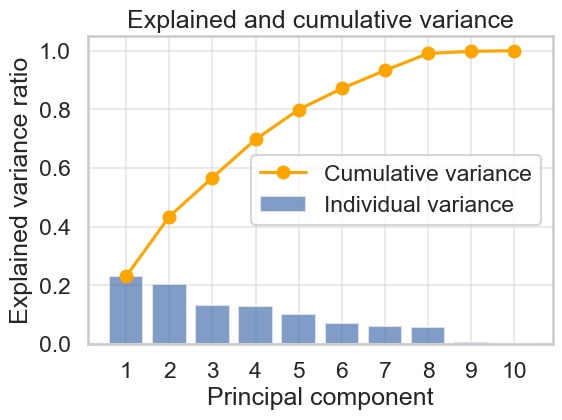

Components needed for 95% variance: 8
Components needed for 75% variance: 5


In [15]:
# PCA analysis
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca_full = PCA().fit(X_scaled)

explained_var = pca_full.explained_variance_ratio_  # array containing % of variance explained by each PC
cumulative_explained = np.cumsum(explained_var)  # running total

components = np.arange(1, len(explained_var) + 1)  # start axis at 1 rather than 0

plt.figure(figsize=(6, 4))
plt.bar(np.arange(1, len(explained_var) + 1), explained_var, alpha=0.7, label='Individual variance')
plt.plot(np.arange(1, len(explained_var) + 1), cumulative_explained, marker='o', color='orange', label='Cumulative variance')
plt.xlabel('Principal component')
plt.ylabel('Explained variance ratio')
plt.xticks(components)
plt.title('Explained and cumulative variance')
plt.legend()
plt.grid(alpha=0.4)
plt.show()

print(f"Components needed for 95% variance: {np.argmax(cumulative_explained >= 0.95) + 1}")
print(f"Components needed for 75% variance: {np.argmax(cumulative_explained >= 0.75) + 1}")

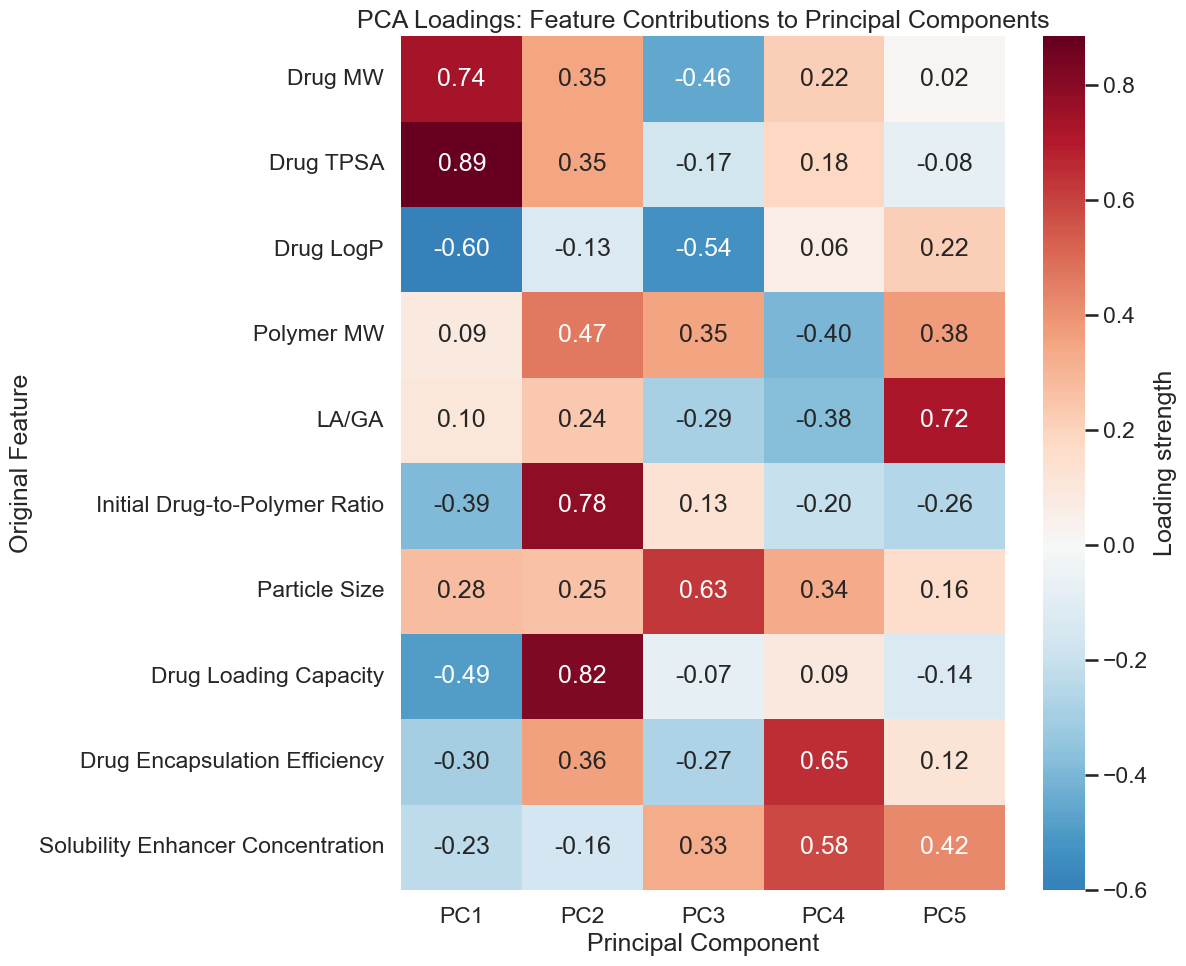

In [16]:
# This cell creates a PCA Loadings Heatmap that shows which features contribute to each...
    #...Principal Component. Extracted loadings and plotted heatmap with parameters with the help of ChatGPT. 
pca_full = PCA().fit(X_scaled)
loadings = pca_full.components_.T * np.sqrt(pca_full.explained_variance_)

loadings_df = pd.DataFrame(
    loadings,
    columns=[f'PC{i+1}' for i in range(loadings.shape[1])],
    index=X.columns
)
n_components = 5 # first 5 PCs
plt.figure(figsize=(12, 10))
sns.heatmap(loadings_df.iloc[:, :n_components], 
            cmap='RdBu_r', 
            center=0, 
            annot=True, 
            fmt='.2f',
            cbar_kws={'label': 'Loading strength'})
plt.title('PCA Loadings: Feature Contributions to Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Original Feature')
plt.tight_layout()
plt.show()

## Supervised Learning

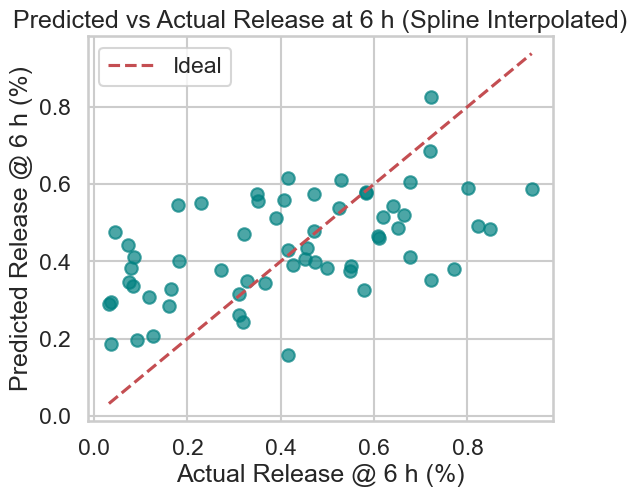

Test Set Performance:
  R^2  = 0.2820
  MAE = 0.1671


In [17]:
X_train, X_test, y_train, y_test_ridge = train_test_split(X, y, test_size=0.20, random_state=42)

model = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0], cv=5)) # linear regression with L2 penalty (expected to be bad)
])

model.fit(X_train, y_train)
y_pred_ridge = model.predict(X_test)

r2 = r2_score(y_test_ridge, y_pred_ridge)
mae = mean_absolute_error(y_test_ridge, y_pred_ridge)

plt.figure(figsize=(6,5))
plt.scatter(y_test_ridge, y_pred_ridge, alpha=0.7, color='teal')
plt.plot([min(y_test_ridge), max(y_test_ridge)],
         [min(y_test_ridge), max(y_test_ridge)], 'r--', label='Ideal')
plt.xlabel(f"Actual Release @ {target_time} h (%)")
plt.ylabel(f"Predicted Release @ {target_time} h (%)")
plt.title(f"Predicted vs Actual Release at {target_time} h (Spline Interpolated)")
plt.legend()
plt.grid(True)
plt.show()
print(f"Test Set Performance:")
print(f"  R^2  = {r2:.4f}")
print(f"  MAE = {mae:.4f}")

The linear regression with L2 (ridge) penalty attempts to fit a linear relationship between the formulation features and drug release. The model assumes that release can be predicted as a weighted sum of the features. But drug release kinetics are not linear. The poor performance of ridge regression (R^2 = 0.2820) demonstrates that a simple linear model is insufficient. This proposes the need for nonlinear approaches.

Cross-Validation Results (5-fold):
  R^2  = 0.4258 (+/- 0.0911)
  MAE  = 0.1474 (+/- 0.0176)



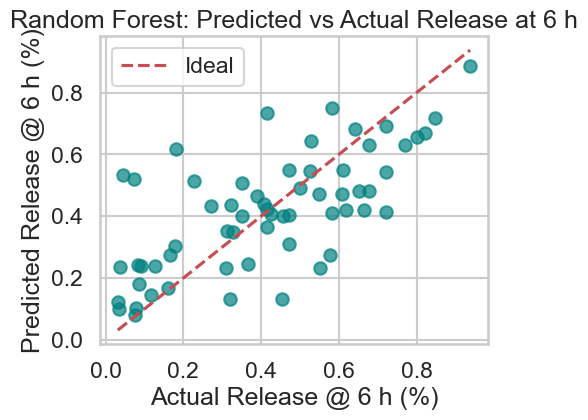

Test Set Performance:
  R^2  = 0.4577
  MAE = 0.1369

Top 10 Most Important Features:


,feature,importance
8,Drug Encapsulation Efficiency,0.236883
3,Polymer MW,0.193855
6,Particle Size,0.112756
0,Drug MW,0.109903
7,Drug Loading Capacity,0.103695
5,Initial Drug-to-Polymer Ratio,0.083580
1,Drug TPSA,0.068671
2,Drug LogP,0.063427
9,Solubility Enhancer Concentration,0.017962
4,LA/GA,0.009268


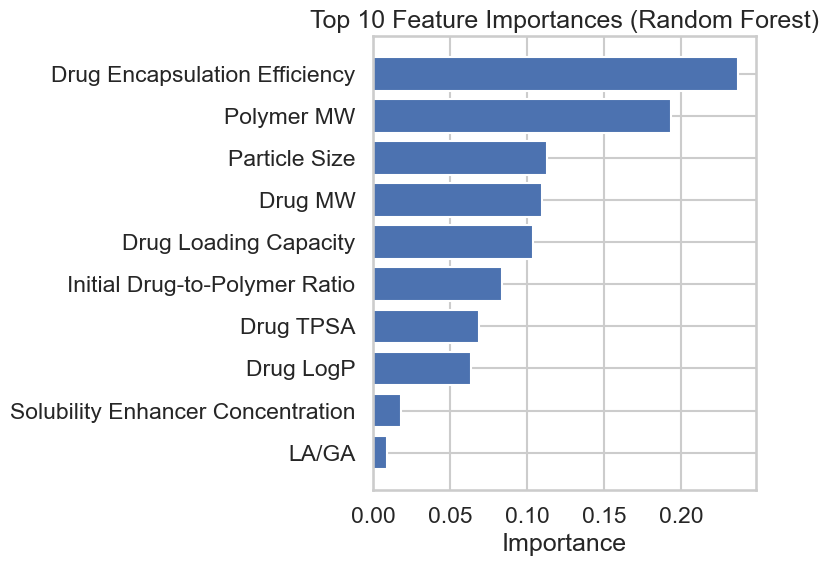

In [18]:
X_train, X_test, y_train, y_test_rf6 = train_test_split(X, y, test_size=0.20, random_state=42)

model = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42))
])

cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
cv_mae_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

print(f"Cross-Validation Results (5-fold):")
print(f"  R^2  = {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print(f"  MAE  = {-cv_mae_scores.mean():.4f} (+/- {cv_mae_scores.std():.4f})")
print()

model.fit(X_train, y_train)
y_pred_rf6 = model.predict(X_test)

r2 = r2_score(y_test_rf6, y_pred_rf6)
mae = mean_absolute_error(y_test_rf6, y_pred_rf6)

plt.figure(figsize=(5,4))
plt.scatter(y_test_rf6, y_pred_rf6, alpha=0.7, color='teal')
plt.plot([min(y_test_rf6), max(y_test_rf6)],
         [min(y_test_rf6), max(y_test_rf6)], 'r--', label='Ideal')
plt.xlabel(f"Actual Release @ {target_time} h (%)")
plt.ylabel(f"Predicted Release @ {target_time} h (%)")
plt.title(f"Random Forest: Predicted vs Actual Release at {target_time} h")
plt.legend()
plt.grid(True)
plt.show()

print(f"Test Set Performance:")
print(f"  R^2  = {r2:.4f}")
print(f"  MAE = {mae:.4f}")
print()

# Feature importances
importances = model.named_steps['rf'].feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values('importance', ascending=False)
print(f"Top 10 Most Important Features:")
display(feature_importance_df.head(10))
plt.figure(figsize=(8,6))
plt.barh(feature_importance_df.head(10)['feature'], feature_importance_df.head(10)['importance'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

The R^2 value is slightly better than logistic regression. There is some variation across the folds in cross fold validation (R^2  = 0.4258 (+/- 0.0911)). One idea to improve model performance is utilize GridSearchCV to identify optimal hyperparameters within an expansive defined hyperparameter grid (hyperparameter grid developed with assistance of Claude 4.5). 

Testing 108 combinations with 5-fold CV
Total fits: 540

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters: {'rf__max_depth': 20, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Best CV R^2: 0.4296


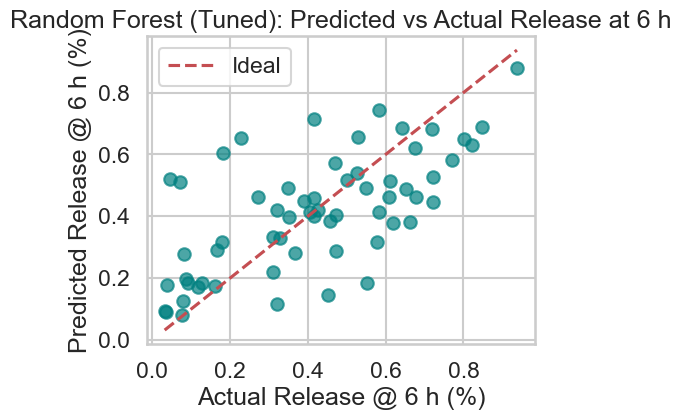


Test Set Performance:
  R^2  = 0.4241
  MAE = 0.1404

Top 10 Most Important Features:


,feature,importance
8,Drug Encapsulation Efficiency,0.246579
3,Polymer MW,0.202497
0,Drug MW,0.113247
6,Particle Size,0.101408
7,Drug Loading Capacity,0.099521
5,Initial Drug-to-Polymer Ratio,0.078472
1,Drug TPSA,0.069395
2,Drug LogP,0.063676
9,Solubility Enhancer Concentration,0.016831
4,LA/GA,0.008373


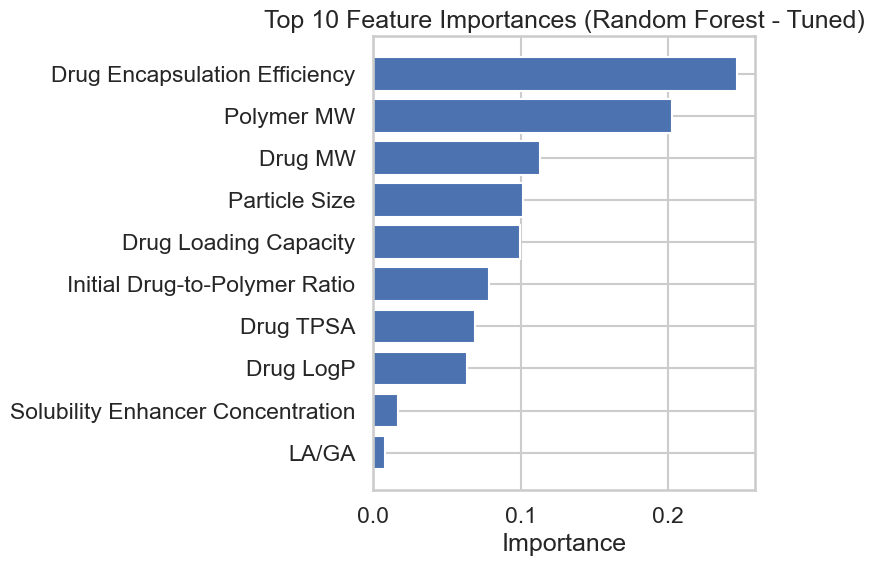

In [19]:
from sklearn.model_selection import GridSearchCV

model = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))
])

param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [10, 20, 30, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

total_combinations = (len(param_grid['rf__n_estimators']) * 
                     len(param_grid['rf__max_depth']) * 
                     len(param_grid['rf__min_samples_split']) * 
                     len(param_grid['rf__min_samples_leaf']))

print(f"Testing {total_combinations} combinations with 5-fold CV")
print(f"Total fits: {total_combinations * 5}\n")

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print(f"\n{'='*60}")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV R^2: {grid_search.best_score_:.4f}")
print('='*60)

# Use best model to predict on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

r2 = r2_score(y_test_rf6, y_pred)
mae = mean_absolute_error(y_test_rf6, y_pred)

plt.figure(figsize=(5,4))
plt.scatter(y_test_rf6, y_pred, alpha=0.7, color='teal')
plt.plot([min(y_test_rf6), max(y_test_rf6)],
         [min(y_test_rf6), max(y_test_rf6)], 'r--', label='Ideal')
plt.xlabel(f"Actual Release @ {target_time} h (%)")
plt.ylabel(f"Predicted Release @ {target_time} h (%)")
plt.title(f"Random Forest (Tuned): Predicted vs Actual Release at {target_time} h")
plt.legend()
plt.grid(True)
plt.show()

print(f"\nTest Set Performance:")
print(f"  R^2  = {r2:.4f}")
print(f"  MAE = {mae:.4f}")
print()

importances = best_model.named_steps['rf'].feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

print(f"Top 10 Most Important Features:")
display(feature_importance_df.head(10))

# Plot feature importances
plt.figure(figsize=(8,6))
plt.barh(feature_importance_df.head(10)['feature'], feature_importance_df.head(10)['importance'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances (Random Forest - Tuned)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Perhaps the cubic spline at t=6 is too early. Let's try a range of values and see what happens. 

,target_time,n_formulations,cv_r2_mean,cv_r2_std,test_r2,test_mae
0,2,318,0.347449,0.136766,0.136392,0.142382
1,4,312,0.424342,0.142004,0.278544,0.146623
2,6,305,0.438613,0.146412,0.311362,0.151590
3,8,299,-9.719470,14.247750,-3.937138,0.320919
4,10,292,0.415194,0.136073,0.521986,0.158574
5,12,255,0.085218,0.309286,-0.074745,0.219822
6,15,242,-0.648794,1.369063,0.077074,0.196089
7,18,232,-1.265122,2.610485,0.009710,0.192003
8,20,216,-0.237058,0.588183,0.030682,0.139500


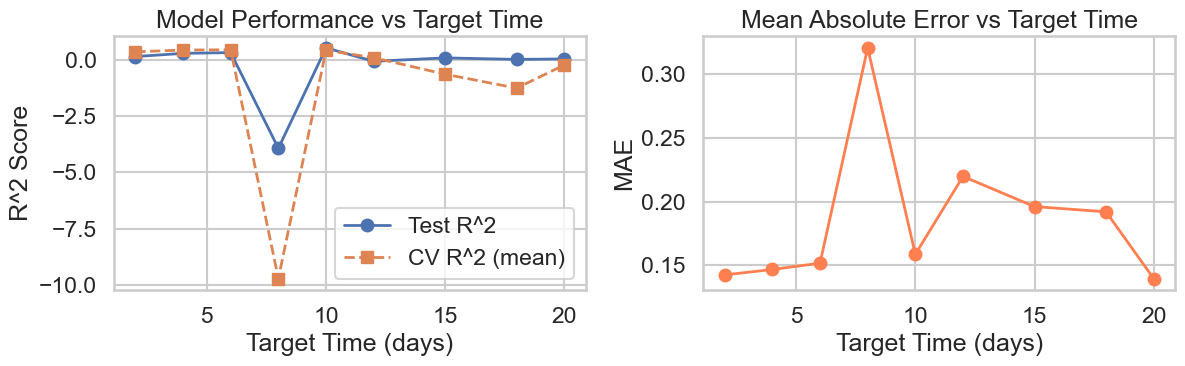


Best target time: 10.0h with Test R^2 = 0.5220


In [20]:
target_times = [2, 4, 6, 8, 10, 12, 15, 18, 20]
results = []

for test_target_time in target_times:    
    time_col = [c for c in df.columns if c.lower().startswith('time')][0]
    release_col = [c for c in df.columns if 'release' in c.lower()][0]
    
    start_idx = df.index[df[time_col] == 0].tolist()
    start_idx.append(len(df))
    
    interp_rows = []
    
    for i in range(len(start_idx)-1):
        sub = df.iloc[start_idx[i]:start_idx[i+1]].copy()
        tmin, tmax = sub[time_col].min(), sub[time_col].max()
        
        if tmin <= test_target_time <= tmax and len(sub) > 3:
            sub_sorted = sub.sort_values(time_col).drop_duplicates(subset=time_col, keep='first')
            
            if len(sub_sorted) > 3:
                try:
                    f_spline = interp1d(sub_sorted[time_col], sub_sorted[release_col], 
                                       kind='cubic', fill_value="extrapolate")
                    interpolated_release = float(f_spline(test_target_time))
                    
                    formulation_row = sub.iloc[0].copy()
                    formulation_row[time_col] = test_target_time
                    formulation_row[release_col] = interpolated_release
                    interp_rows.append(formulation_row)
                except:
                    continue
    
    df_interp_temp = pd.DataFrame(interp_rows).reset_index(drop=True)
    
    if len(df_interp_temp) < 50:
        print(f"  Only {len(df_interp_temp)} formulations cover t={test_target_time}h - skipping")
        continue
    
    y_temp = df_interp_temp[release_col].values
    X_temp = df_interp_temp.drop(columns=[time_col, release_col])
    X_temp = X_temp.select_dtypes(include='number').fillna(X_temp.select_dtypes(include='number').mean())
    
    X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.20, random_state=42)
    
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42))
    ])
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if test_target_time == 10:
        X_test_10 = X_test.copy()
        y_test_10 = y_test.copy()
        y_pred_10 = y_pred.copy()
    test_r2 = r2_score(y_test, y_pred)
    test_mae = mean_absolute_error(y_test, y_pred)    
    results.append({
        'target_time': test_target_time,
        'n_formulations': len(df_interp_temp),
        'cv_r2_mean': cv_scores.mean(),
        'cv_r2_std': cv_scores.std(),
        'test_r2': test_r2,
        'test_mae': test_mae
    })

results_df = pd.DataFrame(results)
display(results_df)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(results_df['target_time'], results_df['test_r2'], 'o-', label='Test R^2', linewidth=2)
ax1.plot(results_df['target_time'], results_df['cv_r2_mean'], 's--', label='CV R^2 (mean)', linewidth=2)
ax1.set_xlabel('Target Time (days)')
ax1.set_ylabel('R^2 Score')
ax1.set_title('Model Performance vs Target Time')
ax1.legend()
ax1.grid(True)

ax2.plot(results_df['target_time'], results_df['test_mae'], 'o-', color='coral', linewidth=2)
ax2.set_xlabel('Target Time (days)')
ax2.set_ylabel('MAE')
ax2.set_title('Mean Absolute Error vs Target Time')
ax2.grid(True)

plt.tight_layout()
plt.show()

best_time = results_df.loc[results_df['test_r2'].idxmax()]
print(f"\nBest target time: {best_time['target_time']}h with Test R^2 = {best_time['test_r2']:.4f}")

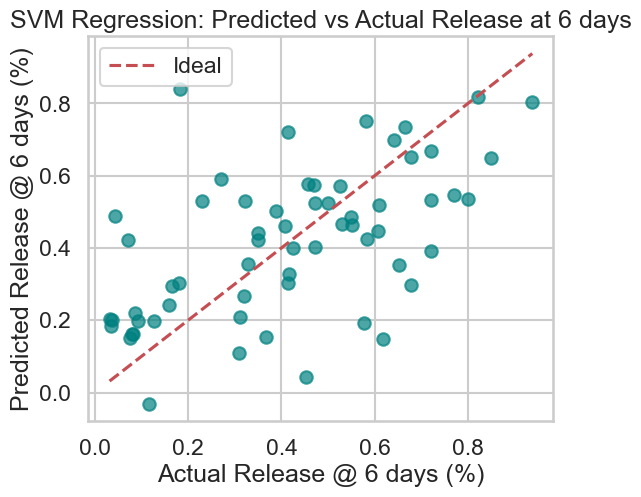

Test Set Performance:
  R^2  = 0.2441
  MAE = 0.1632


In [21]:
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test_svm = train_test_split(X, y, test_size=0.20, random_state=42)

svm_model = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf', C=10, gamma='scale', epsilon=0.1))
])

svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

r2 = r2_score(y_test_svm, y_pred_svm)
mae = mean_absolute_error(y_test_svm, y_pred_svm)

plt.figure(figsize=(6,5))
plt.scatter(y_test_svm, y_pred_svm, alpha=0.7, color='teal')
plt.plot([min(y_test_svm), max(y_test_svm)],
         [min(y_test_svm), max(y_test_svm)], 'r--', label='Ideal')
plt.xlabel(f"Actual Release @ {target_time} days (%)")
plt.ylabel(f"Predicted Release @ {target_time} days (%)")
plt.title(f"SVM Regression: Predicted vs Actual Release at {target_time} days")
plt.legend()
plt.grid(True)
plt.show()

print(f"Test Set Performance:")
print(f"  R^2  = {r2:.4f}")
print(f"  MAE = {mae:.4f}")

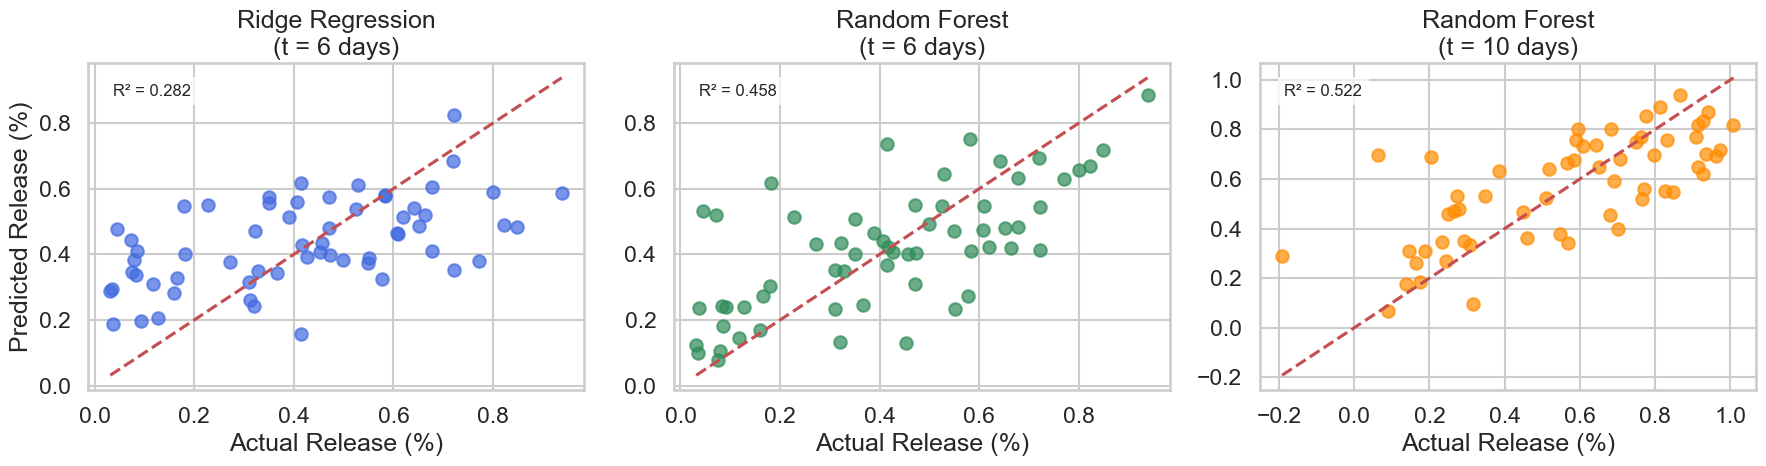

In [22]:
from sklearn.metrics import r2_score

r2_ridge = r2_score(y_test_ridge, y_pred_ridge)
r2_rf6   = r2_score(y_test_rf6, y_pred_rf6)
r2_rf10  = r2_score(y_test_10, y_pred_10)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].scatter(y_test_ridge, y_pred_ridge, alpha=0.7, color='royalblue')
axs[0].plot([min(y_test_ridge), max(y_test_ridge)],
            [min(y_test_ridge), max(y_test_ridge)], 'r--')
axs[0].set_title("Ridge Regression\n(t = 6 days)")
axs[0].set_xlabel("Actual Release (%)")
axs[0].set_ylabel("Predicted Release (%)")
axs[0].text(0.05, 0.90, f"R² = {r2_ridge:.3f}", transform=axs[0].transAxes,
            fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
axs[0].grid(True)

axs[1].scatter(y_test_rf6, y_pred_rf6, alpha=0.7, color='seagreen')
axs[1].plot([min(y_test_rf6), max(y_test_rf6)],
            [min(y_test_rf6), max(y_test_rf6)], 'r--')
axs[1].set_title("Random Forest\n(t = 6 days)")
axs[1].set_xlabel("Actual Release (%)")
axs[1].text(0.05, 0.90, f"R² = {r2_rf6:.3f}", transform=axs[1].transAxes,
            fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
axs[1].grid(True)

axs[2].scatter(y_test_10, y_pred_10, alpha=0.7, color='darkorange')
axs[2].plot([min(y_test_10), max(y_test_10)],
            [min(y_test_10), max(y_test_10)], 'r--')
axs[2].set_title("Random Forest\n(t = 10 days)")
axs[2].set_xlabel("Actual Release (%)")
axs[2].text(0.05, 0.90, f"R² = {r2_rf10:.3f}", transform=axs[2].transAxes,
            fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
axs[2].grid(True)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

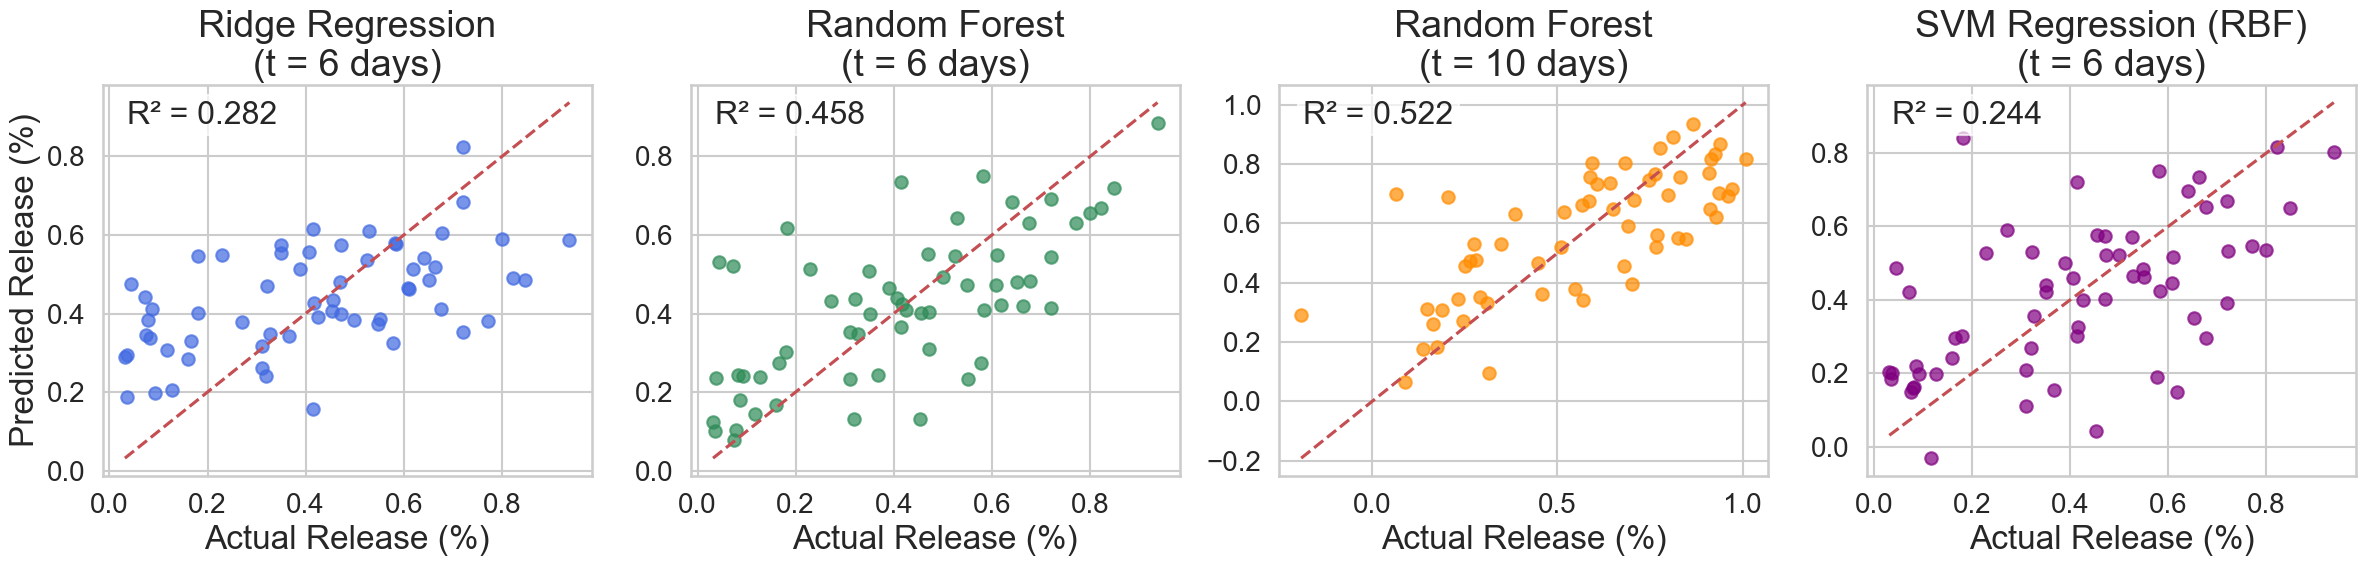

In [23]:
r2_ridge = r2_score(y_test_ridge, y_pred_ridge)
r2_rf6   = r2_score(y_test_rf6, y_pred_rf6)
r2_rf10  = r2_score(y_test_10, y_pred_10)
r2_svm   = r2_score(y_test_svm, y_pred_svm)

fig, axs = plt.subplots(1, 4, figsize=(24, 6))
TITLE_SIZE = 27
LABEL_SIZE = 24
TICK_SIZE  = 20
axs[0].scatter(y_test_ridge, y_pred_ridge, alpha=0.7, color='royalblue')
axs[0].plot([min(y_test_ridge), max(y_test_ridge)],
            [min(y_test_ridge), max(y_test_ridge)], 'r--')
axs[0].set_title("Ridge Regression\n(t = 6 days)", fontsize=TITLE_SIZE)
axs[0].set_xlabel("Actual Release (%)", fontsize=LABEL_SIZE)
axs[0].set_ylabel("Predicted Release (%)", fontsize=LABEL_SIZE)
axs[0].tick_params(axis='both', labelsize=TICK_SIZE)
axs[0].text(0.05, 0.90, f"R² = {r2_ridge:.3f}", transform=axs[0].transAxes,
            fontsize=23, bbox=dict(facecolor='white', alpha=0.7))
axs[0].grid(True)

axs[1].scatter(y_test_rf6, y_pred_rf6, alpha=0.7, color='seagreen')
axs[1].plot([min(y_test_rf6), max(y_test_rf6)],
            [min(y_test_rf6), max(y_test_rf6)], 'r--')
axs[1].set_title("Random Forest\n(t = 6 days)", fontsize=TITLE_SIZE)
axs[1].set_xlabel("Actual Release (%)", fontsize=LABEL_SIZE)
axs[1].tick_params(axis='both', labelsize=TICK_SIZE)
axs[1].text(0.05, 0.90, f"R² = {r2_rf6:.3f}", transform=axs[1].transAxes,
            fontsize=23, bbox=dict(facecolor='white', alpha=0.7))
axs[1].grid(True)

axs[2].scatter(y_test_10, y_pred_10, alpha=0.7, color='darkorange')
axs[2].plot([min(y_test_10), max(y_test_10)],
            [min(y_test_10), max(y_test_10)], 'r--')
axs[2].set_title("Random Forest\n(t = 10 days)", fontsize=TITLE_SIZE)
axs[2].set_xlabel("Actual Release (%)", fontsize=LABEL_SIZE)
axs[2].tick_params(axis='both', labelsize=TICK_SIZE)
axs[2].text(0.05, 0.90, f"R² = {r2_rf10:.3f}", transform=axs[2].transAxes,
            fontsize=23, bbox=dict(facecolor='white', alpha=0.7))
axs[2].grid(True)

axs[3].scatter(y_test_svm, y_pred_svm, alpha=0.7, color='purple')
axs[3].plot([min(y_test_svm), max(y_test_svm)],
            [min(y_test_svm), max(y_test_svm)], 'r--')
axs[3].set_title("SVM Regression (RBF)\n(t = 6 days)", fontsize=TITLE_SIZE)
axs[3].set_xlabel("Actual Release (%)", fontsize=LABEL_SIZE)
axs[3].tick_params(axis='both', labelsize=TICK_SIZE)
axs[3].text(0.05, 0.90, f"R² = {r2_svm:.3f}", transform=axs[3].transAxes,
            fontsize=23, bbox=dict(facecolor='white', alpha=0.7))
axs[3].grid(True)
plt.tight_layout()
plt.savefig("model_comparison_extended.png", dpi=300, bbox_inches="tight")
plt.show()

**Weibull Fitting**

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# F(t) = A * (1 - exp(-(t/tau)^beta))
def weibull_model(t, A, tau, beta):
    return A * (1.0 - np.exp(-(t / tau) ** beta))

In [25]:
form_id_col = "Formulation Index"
time_col = [c for c in df.columns if c.lower().startswith("time")][0]
release_col = [c for c in df.columns if "release" in c.lower()][0]

fit_rows = []

for fid, sub in df.groupby(form_id_col):
    sub = sub.sort_values(time_col).drop_duplicates(subset=time_col, keep="first")
    
    t = sub[time_col].astype(float).values
    y = np.clip(sub[release_col].astype(float).values, 0.0, 1.0)

    if len(t) < 4:
        continue

    try:
        # initial guesses
        p0 = [min(1.0, max(y)), np.median(t[t > 0]), 1.0]
        bounds = ([0, 1e-6, 1e-3], [1.2, np.inf, 10])

        popt, _ = curve_fit(
            weibull_model, t, y, p0=p0, bounds=bounds, maxfev=20000
        )

        A, tau, beta = popt
        y_fit = weibull_model(t, A, tau, beta)

        r2 = r2_score(y, y_fit)
        mae = mean_absolute_error(y, y_fit)

        row = sub.iloc[0].copy()
        row["weibull_A"] = A
        row["weibull_tau"] = tau
        row["weibull_beta"] = beta
        row["fit_r2"] = r2
        row["fit_mae"] = mae

        fit_rows.append(row)

    except:
        continue

df_weibull = pd.DataFrame(fit_rows).reset_index(drop=True)
print(f"Weibull fits computed: {len(df_weibull)}")
df_weibull.head(10)

Weibull fits computed: 321


,Formulation Index,Drug MW,Drug TPSA,Drug LogP,Polymer MW,LA/GA,Initial Drug-to-Polymer Ratio,Particle Size,Drug Loading Capacity,Drug Encapsulation Efficiency,Solubility Enhancer Concentration,Time,Release,weibull_A,weibull_tau,weibull_beta,fit_r2,fit_mae
0,1.0,639.830,116.04,5.7289,75.0,3.0,0.666667,47.723,35.41,88.3,0.5,0.0,0.0,0.925686,180.940306,10.000000,0.979847,0.040638
1,2.0,392.467,94.83,1.8957,12.0,1.0,0.111111,1.800,6.60,66.0,0.0,0.0,0.0,1.003614,1.390173,0.579583,0.998547,0.008928
2,3.0,392.467,94.83,1.8957,12.0,1.0,0.111111,12.500,8.60,85.9,0.0,0.0,0.0,1.042316,7.159416,1.051840,0.992683,0.024139
3,4.0,392.467,94.83,1.8957,12.0,1.0,0.111111,29.300,8.70,86.8,0.0,0.0,0.0,1.011402,7.372043,1.700846,0.987483,0.035394
4,5.0,392.467,94.83,1.8957,12.0,1.0,0.111111,58.000,9.00,90.1,0.0,0.0,0.0,0.977105,7.622518,1.858558,0.992381,0.027488
5,6.0,392.467,94.83,1.8957,31.0,1.0,0.111111,1.500,5.80,58.1,0.0,0.0,0.0,1.146576,13.107401,0.977463,0.989368,0.028822
6,7.0,392.467,94.83,1.8957,31.0,1.0,0.111111,12.900,7.50,75.3,0.0,0.0,0.0,1.057929,17.315237,1.923547,0.990530,0.030745
7,8.0,392.467,94.83,1.8957,31.0,1.0,0.111111,34.800,8.50,85.3,0.0,0.0,0.0,1.002200,16.366158,3.340358,0.994512,0.024042
8,9.0,392.467,94.83,1.8957,31.0,1.0,0.111111,61.300,8.60,86.1,0.0,0.0,0.0,0.999030,16.254927,3.512342,0.998637,0.011460
9,10.0,392.467,94.83,1.8957,12.0,1.0,0.052632,35.000,4.30,86.0,0.0,0.0,0.0,0.997335,5.752354,1.798072,0.989883,0.026245


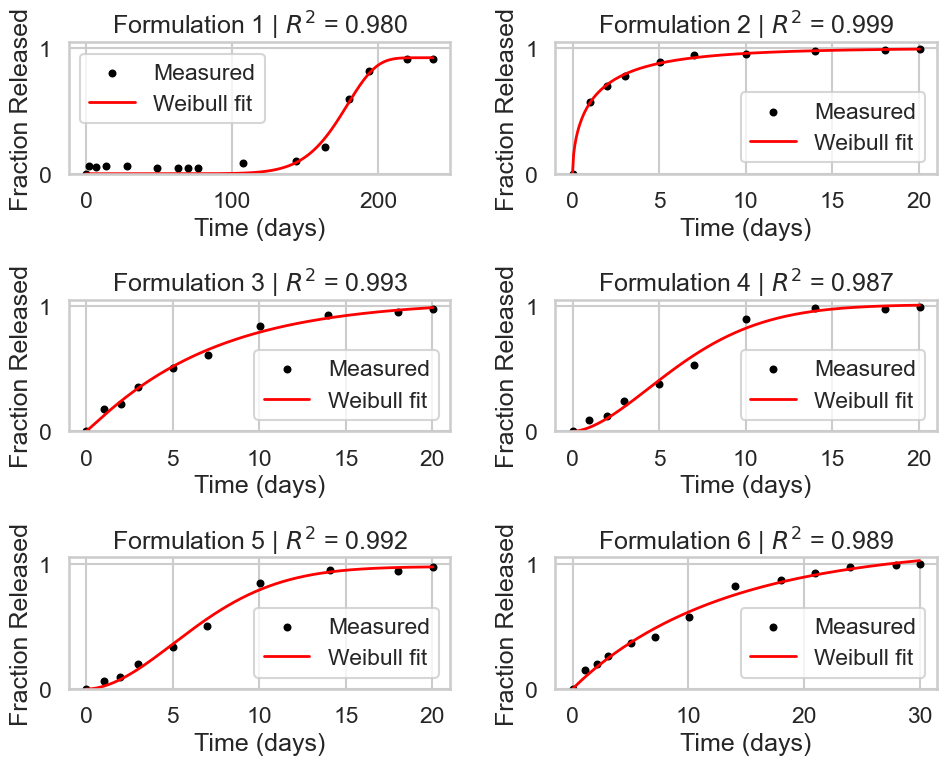

In [26]:
form_id_col = "Formulation Index"
n_plots = 6
shown = 0

plt.figure(figsize=(10, 8))

for fid, sub in df.groupby(form_id_col):
    if shown >= n_plots:
        break

    row = df_weibull[df_weibull[form_id_col] == fid]
    if len(row) == 0:
        continue

    A = row["weibull_A"].values[0]
    tau = row["weibull_tau"].values[0]
    beta = row["weibull_beta"].values[0]
    r2_fit = row["fit_r2"].values[0]

    # Original release curve
    sub = sub.sort_values(time_col).drop_duplicates(subset=time_col, keep="first")
    t = sub[time_col].astype(float).values
    y = np.clip(sub[release_col].astype(float).values, 0.0, 1.0)

    # Weibull curve
    t_smooth = np.linspace(t.min(), t.max(), 300)
    y_fit = weibull_model(t_smooth, A, tau, beta)

    # Plot
    plt.subplot(3, 2, shown + 1)
    plt.scatter(t, y, color="black", s=18, label="Measured")
    plt.plot(t_smooth, y_fit, color="red", linewidth=2, label="Weibull fit")
    plt.title(f"Formulation {int(fid)} | $R^2$ = {r2_fit:.3f}")
    plt.xlabel("Time (days)")
    plt.ylabel("Fraction Released")
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend()

    shown += 1

plt.tight_layout()
plt.show()

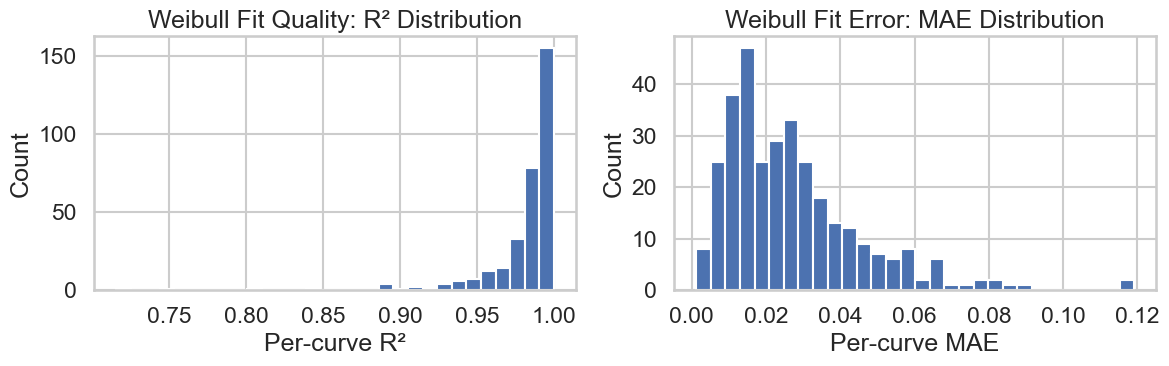

Weibull Fit Quality Summary (across all formulations):

R² (n=321):
  min   = 0.7153
  mean  = 0.9810
  median= 0.9899
  max   = 1.0000

MAE (n=321):
  min   = 0.0012
  mean  = 0.0270
  median= 0.0232
  max   = 0.1191


In [27]:
r2_vals = df_weibull["fit_r2"].dropna()
mae_vals = df_weibull["fit_mae"].dropna()
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].hist(r2_vals, bins=30)
axs[0].set_title("Weibull Fit Quality: R² Distribution")
axs[0].set_xlabel("Per-curve R²")
axs[0].set_ylabel("Count")
axs[0].grid(True)

axs[1].hist(mae_vals, bins=30)
axs[1].set_title("Weibull Fit Error: MAE Distribution")
axs[1].set_xlabel("Per-curve MAE")
axs[1].set_ylabel("Count")
axs[1].grid(True)

plt.tight_layout()
plt.show()

print("Weibull Fit Quality Summary (across all formulations):\n")

print(f"R² (n={len(r2_vals)}):")
print(f"  min   = {r2_vals.min():.4f}")
print(f"  mean  = {r2_vals.mean():.4f}")
print(f"  median= {r2_vals.median():.4f}")
print(f"  max   = {r2_vals.max():.4f}")
print()

print(f"MAE (n={len(mae_vals)}):")
print(f"  min   = {mae_vals.min():.4f}")
print(f"  mean  = {mae_vals.mean():.4f}")
print(f"  median= {mae_vals.median():.4f}")
print(f"  max   = {mae_vals.max():.4f}")

In [28]:
# Build dataset: formulation descriptors → Weibull parameters

target_params = ["weibull_A", "weibull_tau", "weibull_beta"]

# Features: formulation descriptors only
feature_cols = [
    "Drug MW",
    "Drug TPSA",
    "Drug LogP",
    "Polymer MW",
    "LA/GA",
    "Initial Drug-to-Polymer Ratio",
    "Particle Size",
    "Drug Loading Capacity",
    "Drug Encapsulation Efficiency",
    "Solubility Enhancer Concentration"
]

df_param = df_weibull.copy()

X = df_param[feature_cols]
y = df_param[target_params]

print("Feature matrix X shape:", X.shape)
print("Target matrix y shape:", y.shape)


display(df_param[["Formulation Index"] + target_params].head())

Feature matrix X shape: (321, 10)
Target matrix y shape: (321, 3)


,Formulation Index,weibull_A,weibull_tau,weibull_beta
0,1.0,0.925686,180.940306,10.000000
1,2.0,1.003614,1.390173,0.579583
2,3.0,1.042316,7.159416,1.051840
3,4.0,1.011402,7.372043,1.700846
4,5.0,0.977105,7.622518,1.858558


In [29]:
from sklearn.linear_model import Ridge

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
ridge_model = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=1.0))
])

ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

print("Ridge Regression Performance (predicting Weibull params):")
for i, param in enumerate(target_params):
    r2 = r2_score(y_test.iloc[:, i], y_pred_ridge[:, i])
    mae = mean_absolute_error(y_test.iloc[:, i], y_pred_ridge[:, i])
    print(f"  {param}: R^2 = {r2:.3f}, MAE = {mae:.3f}")

Ridge Regression Performance (predicting Weibull params):
  weibull_A: R^2 = 0.011, MAE = 0.135
  weibull_tau: R^2 = -0.038, MAE = 10.272
  weibull_beta: R^2 = 0.017, MAE = 0.821


In [30]:
from sklearn.ensemble import RandomForestRegressor

rf_model = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestRegressor(
        n_estimators=300,
        max_depth=15,
        random_state=42
    ))
])

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Performance (predicting Weibull params):")
for i, param in enumerate(target_params):
    r2 = r2_score(y_test.iloc[:, i], y_pred_rf[:, i])
    mae = mean_absolute_error(y_test.iloc[:, i], y_pred_rf[:, i])
    print(f"  {param}: R^2 = {r2:.3f}, MAE = {mae:.3f}")

Random Forest Performance (predicting Weibull params):
  weibull_A: R^2 = 0.197, MAE = 0.116
  weibull_tau: R^2 = 0.095, MAE = 8.577
  weibull_beta: R^2 = 0.156, MAE = 0.655


Epoch 100/100, Loss: 0.3622, Train R²: 0.645, Test R²: -0.385


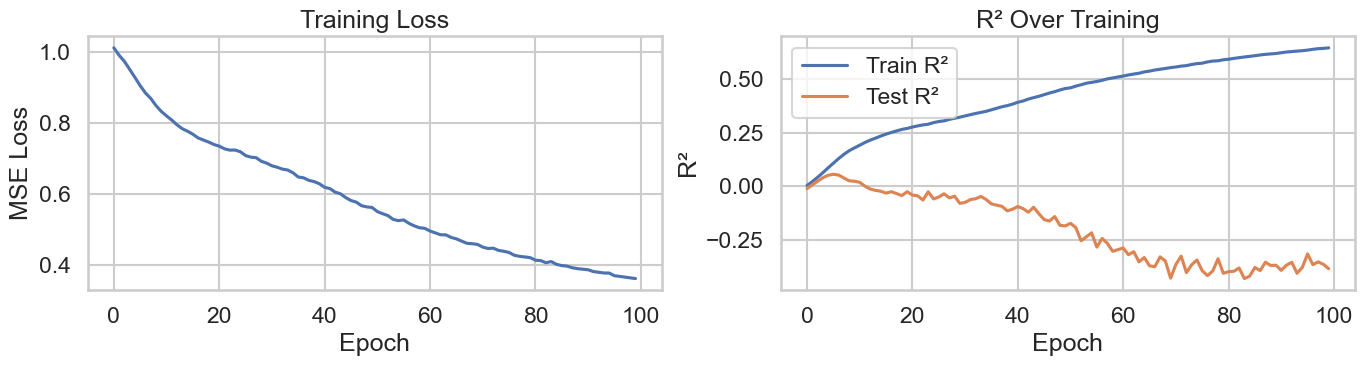


Neural Network Performance (predicting Weibull params):
  weibull_A: R^2 = -0.279, MAE = 0.140
  weibull_tau: R^2 = -1.105, MAE = 12.161
  weibull_beta: R^2 = -0.111, MAE = 0.813


In [31]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class WeibullPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, output_dim))
    def forward(self, x): return self.net(x)

def compute_r2(y_true, y_pred):
    ss_res = ((y_true - y_pred) ** 2).sum()
    ss_tot = ((y_true - y_true.mean()) ** 2).sum()
    return 1 - (ss_res / ss_tot)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_test_scaled, dtype=torch.float32)

train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

input_dim = len(feature_cols)
hidden_dim = 64
output_dim = len(target_params)

model = WeibullPredictor(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 100
losses = []
train_r2s = []
test_r2s = []

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    losses.append(epoch_loss / len(train_loader))
    
    model.eval()
    with torch.no_grad():
        y_pred_train = model(X_train_t)
        y_pred_test = model(X_test_t)
        train_r2 = compute_r2(y_train_t, y_pred_train).item()
        test_r2 = compute_r2(y_test_t, y_pred_test).item()
        train_r2s.append(train_r2)
        test_r2s.append(test_r2)
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {losses[-1]:.4f}, Train R²: {train_r2:.3f}, Test R²: {test_r2:.3f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(losses)
axes[0].set_title("Training Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("MSE Loss")
axes[0].grid(True)
axes[1].plot(train_r2s, label="Train R²")
axes[1].plot(test_r2s, label="Test R²")
axes[1].set_title("R² Over Training")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("R²")
axes[1].legend()
axes[1].grid(True)
plt.tight_layout()
plt.show()

model.eval()
with torch.no_grad(): y_pred_scaled = model(X_test_t).numpy()
y_pred_nn = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = y_test.values
print("\nNeural Network Performance (predicting Weibull params):")
for i, param in enumerate(target_params):
    r2 = r2_score(y_test_original[:, i], y_pred_nn[:, i])
    mae = mean_absolute_error(y_test_original[:, i], y_pred_nn[:, i])
    print(f"  {param}: R^2 = {r2:.3f}, MAE = {mae:.3f}")

C:\Users\andyk\AppData\Local\Temp\ipykernel_35064\2396563837.py:14: RuntimeWarning: divide by zero encountered in power
  return A * (1.0 - np.exp(-(t / tau) ** beta))
C:\Users\andyk\AppData\Local\Temp\ipykernel_35064\2396563837.py:14: RuntimeWarning: invalid value encountered in power
  return A * (1.0 - np.exp(-(t / tau) ** beta))


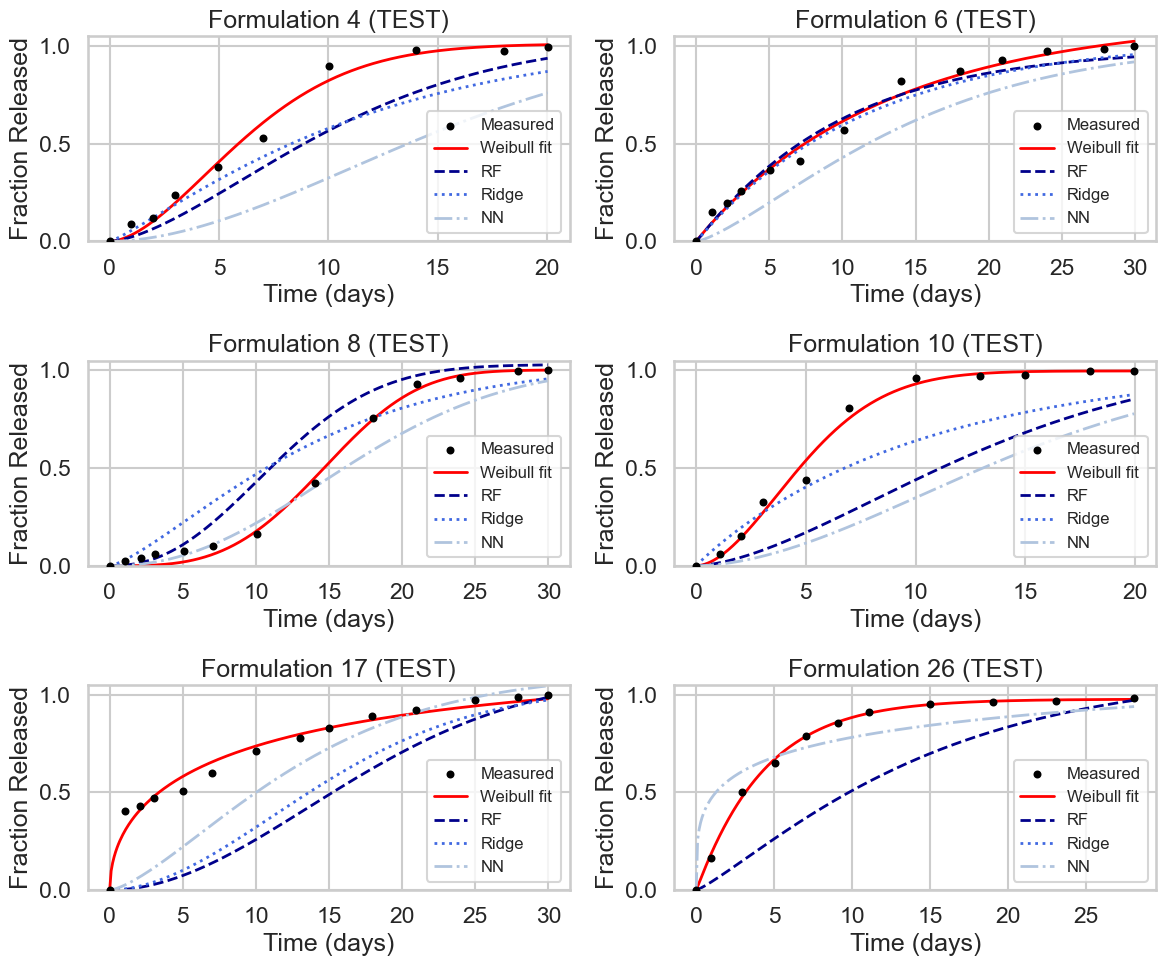

Showing 6 formulations from test set (n=65)


In [32]:
form_id_col = "Formulation Index"
n_plots = 6
shown = 0

test_indices = X_test.index.tolist()

plt.figure(figsize=(12, 10))

for fid, sub in df.groupby(form_id_col):
    if shown >= n_plots:
        break

    row = df_weibull[df_weibull[form_id_col] == fid]
    if len(row) == 0:
        continue
    
    idx = df_param[df_param[form_id_col] == fid].index
    if len(idx) == 0:
        continue
    
    if idx[0] not in test_indices:continue
    
    # Fitted Weibull parameters (from curve fitting)
    A_fit = row["weibull_A"].values[0]
    tau_fit = row["weibull_tau"].values[0]
    beta_fit = row["weibull_beta"].values[0]
    r2_fit = row["fit_r2"].values[0]

    # Predicted Weibull parameters (from Random Forest)
    X_row = df_param.loc[idx, feature_cols]
    pred_rf = rf_model.predict(X_row)[0]
    A_rf, tau_rf, beta_rf = pred_rf[0], pred_rf[1], pred_rf[2]

    # Predicted Weibull parameters (from Ridge)
    pred_ridge = ridge_model.predict(X_row)[0]
    A_ridge, tau_ridge, beta_ridge = pred_ridge[0], pred_ridge[1], pred_ridge[2]

    # Predicted Weibull parameters (from Neural Network)
    X_row_scaled = scaler_X.transform(X_row)
    X_row_t = torch.tensor(X_row_scaled, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        pred_nn_scaled = model(X_row_t).numpy()
    pred_nn = scaler_y.inverse_transform(pred_nn_scaled)[0]
    A_nn, tau_nn, beta_nn = pred_nn[0], pred_nn[1], pred_nn[2]

    # Original release curve
    sub = sub.sort_values(time_col).drop_duplicates(subset=time_col, keep="first")
    t = sub[time_col].astype(float).values
    y = np.clip(sub[release_col].astype(float).values, 0.0, 1.0)

    # Weibull curves
    t_smooth = np.linspace(t.min(), t.max(), 300)
    y_fit = weibull_model(t_smooth, A_fit, tau_fit, beta_fit)
    y_rf = weibull_model(t_smooth, A_rf, tau_rf, beta_rf)
    y_ridge = weibull_model(t_smooth, A_ridge, tau_ridge, beta_ridge)
    y_nn = weibull_model(t_smooth, A_nn, tau_nn, beta_nn)

    # Plot
    plt.subplot(3, 2, shown + 1)
    plt.scatter(t, y, color="black", s=18, label="Measured", zorder=3)
    plt.plot(t_smooth, y_fit, color="red", linewidth=2, label="Weibull fit")
    plt.plot(t_smooth, y_rf, color="darkblue", linewidth=2, linestyle="--", label="RF")
    plt.plot(t_smooth, y_ridge, color="royalblue", linewidth=2, linestyle=":", label="Ridge")
    plt.plot(t_smooth, y_nn, color="lightsteelblue", linewidth=2, linestyle="-.", label="NN")
    plt.title(f"Formulation {int(fid)} (TEST)")
    plt.xlabel("Time (days)")
    plt.ylabel("Fraction Released")
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend(fontsize=12, loc="lower right")

    shown += 1

plt.tight_layout()
plt.show()

print(f"Showing {shown} formulations from test set (n={len(test_indices)})")

The unpredictability isn't in the release mechanism, it's in the feature-to-mechanism mapping.

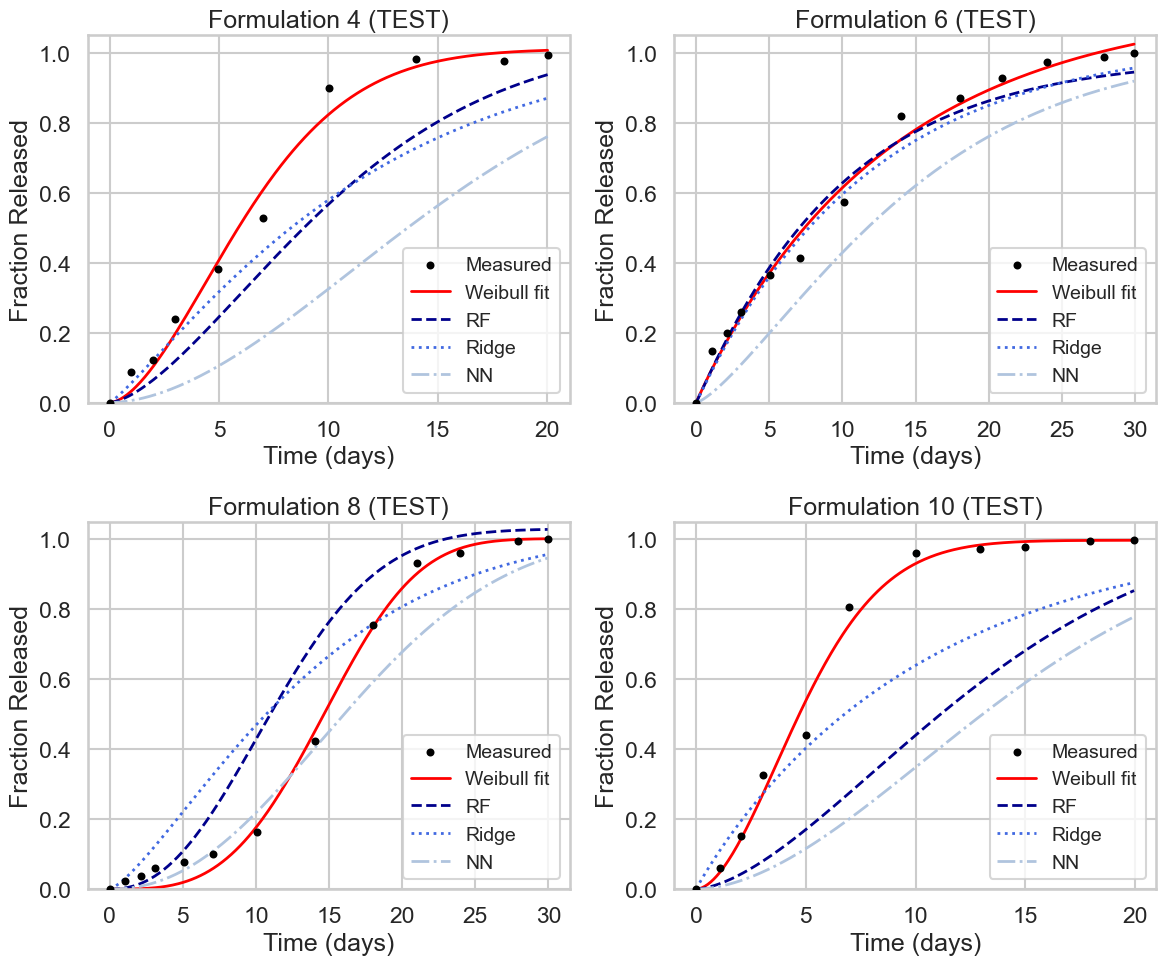

Saved compound plot to: formulation_graphs\test_formulations_compound_4plots.png
Showing 4 formulations from test set (n=65)


In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

form_id_col = "Formulation Index"
n_plots = 4  # <-- only 4 subplots

test_indices = set(X_test.index.tolist())

# Make ONE compound figure with 4 axes
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

shown = 0

for fid, sub in df.groupby(form_id_col):
    if shown >= n_plots:
        break

    row = df_weibull[df_weibull[form_id_col] == fid]
    if len(row) == 0:
        continue

    idx = df_param[df_param[form_id_col] == fid].index
    if len(idx) == 0:
        continue

    if idx[0] not in test_indices:
        continue

    # Fitted Weibull parameters (from curve fitting)
    A_fit   = row["weibull_A"].values[0]
    tau_fit = row["weibull_tau"].values[0]
    beta_fit= row["weibull_beta"].values[0]
    r2_fit  = row["fit_r2"].values[0]

    # Predicted Weibull parameters (from Random Forest)
    X_row = df_param.loc[idx, feature_cols]
    pred_rf = rf_model.predict(X_row)[0]
    A_rf, tau_rf, beta_rf = pred_rf[0], pred_rf[1], pred_rf[2]

    # Predicted Weibull parameters (from Ridge)
    pred_ridge = ridge_model.predict(X_row)[0]
    A_ridge, tau_ridge, beta_ridge = pred_ridge[0], pred_ridge[1], pred_ridge[2]

    # Predicted Weibull parameters (from Neural Network)
    X_row_scaled = scaler_X.transform(X_row)
    X_row_t = torch.tensor(X_row_scaled, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        pred_nn_scaled = model(X_row_t).cpu().numpy()
    pred_nn = scaler_y.inverse_transform(pred_nn_scaled)[0]
    A_nn, tau_nn, beta_nn = pred_nn[0], pred_nn[1], pred_nn[2]

    # Original release curve
    sub = sub.sort_values(time_col).drop_duplicates(subset=time_col, keep="first")
    t = sub[time_col].astype(float).values
    y = np.clip(sub[release_col].astype(float).values, 0.0, 1.0)

    # Weibull curves
    t_smooth = np.linspace(t.min(), t.max(), 300)
    y_fit   = weibull_model(t_smooth, A_fit,   tau_fit,   beta_fit)
    y_rf    = weibull_model(t_smooth, A_rf,    tau_rf,    beta_rf)
    y_ridge = weibull_model(t_smooth, A_ridge, tau_ridge, beta_ridge)
    y_nn    = weibull_model(t_smooth, A_nn,    tau_nn,    beta_nn)

    ax = axes[shown]
    ax.scatter(t, y, color="black", s=18, label="Measured", zorder=3)
    ax.plot(t_smooth, y_fit,   color="red",            linewidth=2, label="Weibull fit")
    ax.plot(t_smooth, y_rf,    color="darkblue",       linewidth=2, linestyle="--", label="RF")
    ax.plot(t_smooth, y_ridge, color="royalblue",      linewidth=2, linestyle=":",  label="Ridge")
    ax.plot(t_smooth, y_nn,    color="lightsteelblue", linewidth=2, linestyle="-.", label="NN")

    ax.set_title(f"Formulation {int(fid)} (TEST)")
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Fraction Released")
    ax.set_ylim(0, 1.05)
    ax.grid(True)
    ax.legend(fontsize=14, loc="lower right")

    shown += 1

# Hide any unused panels (in case you found <4)
for k in range(shown, n_plots):
    axes[k].axis("off")

fig.tight_layout()

# Save the compound plot
out_dir = "formulation_graphs"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, f"test_formulations_compound_{shown}plots.png")
fig.savefig(out_path, dpi=600, bbox_inches="tight")

plt.show()
print(f"Saved compound plot to: {out_path}")
print(f"Showing {shown} formulations from test set (n={len(test_indices)})")
